In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the dengue and climate data
dengue_file_path = 'dengue_am.csv'
climate_file_path = 'climate_am.csv'

dengue_data = pd.read_csv(dengue_file_path)
climate_data = pd.read_csv(climate_file_path)

# Filter for train_1 == True and target_1 == True
dengue_data['train_1'] = dengue_data['train_1'].astype(bool)
dengue_data['target_1'] = dengue_data['target_1'].astype(bool)

dengue_train = dengue_data[dengue_data['train_1']]
dengue_target = dengue_data[dengue_data['target_1']]

# Convert date columns to datetime
dengue_train['date'] = pd.to_datetime(dengue_train['date'])
dengue_target['date'] = pd.to_datetime(dengue_target['date'])
climate_data['date'] = pd.to_datetime(climate_data['date'])

# Merge the datasets on 'date'
train_data = pd.merge(dengue_train, climate_data, on='date')
target_data = pd.merge(dengue_target, climate_data, on='date')

# Select relevant columns
columns_to_keep = ['date', 'casos', 'temp_min', 'temp_med', 'temp_max',
                   'precip_min', 'precip_med', 'precip_max', 'precip_tot',
                   'pressure_min', 'pressure_med', 'pressure_max',
                   'rel_humid_min', 'rel_humid_med', 'rel_humid_max',
                   'thermal_range', 'rainy_days']

train_data = train_data[columns_to_keep]
target_data = target_data[columns_to_keep]



<ipython-input-37-86e95359ffce>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-37-86e95359ffce>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Apply Variance Threshold
selector = VarianceThreshold(threshold=0.1)
climate_features = train_data.drop(columns=['casos','date'])
selected_features = selector.fit_transform(climate_features)

# Get the selected feature names
selected_feature_names = climate_features.columns[selector.get_support()]
selected_feature_names = list(selected_feature_names)
print(selected_feature_names)

# Add 'casos' to the selected features
selected_feature_names = ['casos','date'] + selected_feature_names

['temp_min', 'temp_med', 'temp_max', 'precip_max', 'precip_tot', 'rel_humid_min', 'rel_humid_med', 'rel_humid_max', 'thermal_range', 'rainy_days']


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Update train_data and target_data with selected features
train_data = train_data[selected_feature_names]
target_data = target_data[selected_feature_names]


In [ ]:
# Set date as index
train_data.set_index('date', inplace=True)
target_data.set_index('date', inplace=True)

# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
target_scaled = scaler.transform(target_data)

# Prepare the data for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps, 1:])  # Features (exclude 'casos')
        y.append(data[i + n_steps, 0])  # Target ('casos')
    return np.array(X), np.array(y)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(X_train, y_train, epochs=50, verbose=1)


Epoch 1/50
21/21 [==============================] - 1s 4ms/step - loss: 0.0124
Epoch 2/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 3/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 4/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0082
Epoch 5/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 6/50
21/21 [==============================] - 0s 5ms/step - loss: 0.0070
Epoch 7/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0071
Epoch 8/50
21/21 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 9/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 10/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 11/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 12/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 13/50
21/21 [==============================

In [ ]:
# Change Sequence Length
n_steps = 5  # Adjust the sequence length
X_train, y_train = create_sequences(train_scaled, n_steps)
X_target, y_target = create_sequences(target_scaled, n_steps)


# Define the model with more units in the LSTM layers and Dropout
model = Sequential()
model.add(LSTM(1000, activation='relu', return_sequences=True, input_shape=(n_steps, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')



# Train the model
model.fit(X_train, y_train, epochs=500, verbose=1)

Epoch 1/500
21/21 [==============================] - 4s 32ms/step - loss: 0.0084
Epoch 2/500
21/21 [==============================] - 0s 20ms/step - loss: 0.0075
Epoch 3/500
21/21 [==============================] - 0s 21ms/step - loss: 0.0074
Epoch 4/500
21/21 [==============================] - 0s 20ms/step - loss: 0.0074
Epoch 5/500
21/21 [==============================] - 0s 20ms/step - loss: 0.0073
Epoch 6/500
21/21 [==============================] - 0s 20ms/step - loss: 0.0073
Epoch 7/500
21/21 [==============================] - 0s 20ms/step - loss: 0.0072
Epoch 8/500
21/21 [==============================] - 0s 20ms/step - loss: 0.0075
Epoch 9/500
21/21 [==============================] - 0s 19ms/step - loss: 0.0074
Epoch 10/500
21/21 [==============================] - 0s 20ms/step - loss: 0.0072
Epoch 11/500
21/21 [==============================] - 0s 19ms/step - loss: 0.0073
Epoch 12/500
21/21 [==============================] - 0s 20ms/step - loss: 0.0076
Epoch 13/500
21/21 [=====

In [ ]:
# Make predictions
y_pred = model.predict(X_target)

# Inverse transform the predictions and the actual values
# Create a zero matrix with the same shape as the features for inverse transformation
dummy_features = np.zeros((y_pred.shape[0], X_target.shape[2]))

# Concatenate the predictions with dummy features
y_pred_full = np.concatenate((y_pred, dummy_features), axis=1)

# Inverse transform the predictions
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, dummy_features), axis=1))[:, 0]

# Concatenate the actual values with dummy features
y_target_full = np.concatenate((y_target.reshape(-1, 1), dummy_features), axis=1)

# Inverse transform the actual values
y_target_inv = scaler.inverse_transform(np.concatenate((y_target.reshape(-1, 1), dummy_features), axis=1))[:, 0]


2/2 [==============================] - 0s 7ms/step


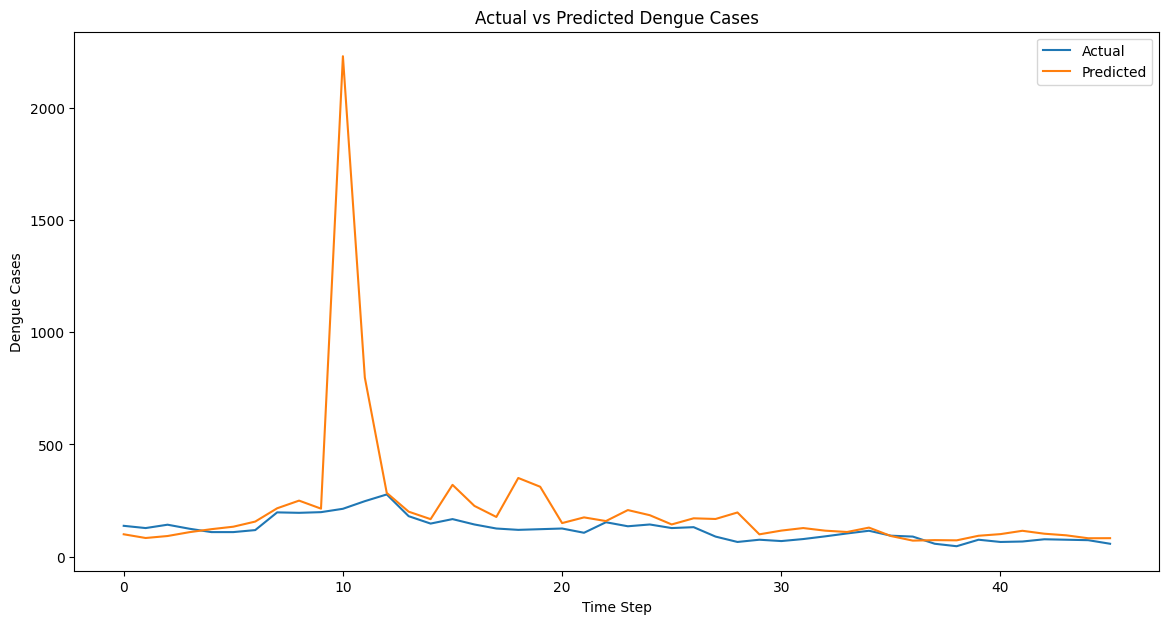

In [ ]:
# Compare the predictions with the actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_target_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Dengue Cases')
plt.title('Actual vs Predicted Dengue Cases')
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(y_target_inv, y_pred_inv)

# Calculate MAPE
mape = np.mean(np.abs((y_target_inv - y_pred_inv) / y_target_inv)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Absolute Error (MAE): 70.99449063141063
Mean Absolute Percentage Error (MAPE): 67.11817496406582%


In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(y_target_inv, y_pred_inv)

# Calculate MAPE
mape = np.mean(np.abs((y_target_inv - y_pred_inv) / y_target_inv)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Error (MAE): 98.26491536953203
Mean Absolute Percentage Error (MAPE): 66.15493388049872%


In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(y_target_inv, y_pred_inv)

# Calculate MAPE
mape = np.mean(np.abs((y_target_inv - y_pred_inv) / y_target_inv)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Error (MAE): 885256.6983324133
Mean Absolute Percentage Error (MAPE): 99.86278484096066%


In [ ]:
# Exclude the 'date' column for PCA
X_train_climate = train_data.drop(columns=['casos', 'date'])
X_target_climate = target_data.drop(columns=['casos', 'date'])

# Standardize the climate features
scaler = StandardScaler()
X_train_climate_scaled = scaler.fit_transform(X_train_climate)
X_target_climate_scaled = scaler.transform(X_target_climate)

# Apply PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_climate_scaled)
X_target_pca = pca.transform(X_target_climate_scaled)

# Create DataFrames with PCA components
n_components = X_train_pca.shape[1]
train_pca_df = pd.DataFrame(X_train_pca, index=train_data.index, columns=[f'PC{i+1}' for i in range(n_components)])
target_pca_df = pd.DataFrame(X_target_pca, index=target_data.index, columns=[f'PC{i+1}' for i in range(n_components)])

# Add the target variable 'casos' and 'date' to the PCA DataFrames
train_pca_df['casos'] = train_data['casos']
train_pca_df['date'] = train_data.index
target_pca_df['casos'] = target_data['casos']
target_pca_df['date'] = target_data.index

# Set date as index
train_pca_df.set_index('date', inplace=True)
target_pca_df.set_index('date', inplace=True)

# Scale the data
train_scaled = scaler.fit_transform(train_pca_df)
target_scaled = scaler.transform(target_pca_df)

n_steps = 5
X_train, y_train = create_sequences(train_scaled, n_steps)
X_target, y_target = create_sequences(target_scaled, n_steps)


In [ ]:
# Define the model with more units in the LSTM layers and Dropout
model = Sequential()
model.add(LSTM(1000, activation='relu', return_sequences=True, input_shape=(n_steps, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=500, verbose=1)

Epoch 1/500
21/21 [==============================] - 3s 22ms/step - loss: 0.8969
Epoch 2/500
21/21 [==============================] - 0s 21ms/step - loss: 0.5834
Epoch 3/500
21/21 [==============================] - 0s 20ms/step - loss: 0.4666
Epoch 4/500
21/21 [==============================] - 0s 21ms/step - loss: 0.4228
Epoch 5/500
21/21 [==============================] - 0s 21ms/step - loss: 0.3903
Epoch 6/500
21/21 [==============================] - 0s 20ms/step - loss: 0.3856
Epoch 7/500
21/21 [==============================] - 0s 20ms/step - loss: 0.3809
Epoch 8/500
21/21 [==============================] - 0s 20ms/step - loss: 0.3505
Epoch 9/500
21/21 [==============================] - 0s 20ms/step - loss: 0.3379
Epoch 10/500
21/21 [==============================] - 0s 19ms/step - loss: 0.3455
Epoch 11/500
21/21 [==============================] - 0s 20ms/step - loss: 0.3258
Epoch 12/500
21/21 [==============================] - 1s 29ms/step - loss: 0.3198
Epoch 13/500
21/21 [=====

In [ ]:
# Make predictions
y_pred = model.predict(X_target)

# Inverse transform the predictions and the actual values
# Create a zero matrix with the same shape as the features for inverse transformation
dummy_features = np.zeros((y_pred.shape[0], X_target.shape[2]))

# Concatenate the predictions with dummy features
y_pred_full = np.concatenate((y_pred, dummy_features), axis=1)

# Inverse transform the predictions
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, dummy_features), axis=1))[:, 0]

# Concatenate the actual values with dummy features
y_target_full = np.concatenate((y_target.reshape(-1, 1), dummy_features), axis=1)

# Inverse transform the actual values
y_target_inv = scaler.inverse_transform(np.concatenate((y_target.reshape(-1, 1), dummy_features), axis=1))[:, 0]

2/2 [==============================] - 0s 7ms/step


In [ ]:
# Make predictions
y_pred = model.predict(X_target)

# Create a zero matrix with the same shape as the features for inverse transformation
dummy_features = np.zeros((y_pred.shape[0], X_target.shape[2]))

# Concatenate the predictions with dummy features for inverse transformation
y_pred_full = np.concatenate((y_pred, dummy_features), axis=1)

# Inverse transform the predictions
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, dummy_features), axis=1))[:, 0]

# Concatenate the actual values with dummy features for inverse transformation
y_target_full = np.concatenate((y_target.reshape(-1, 1), dummy_features), axis=1)

# Inverse transform the actual values
y_target_inv = scaler.inverse_transform(np.concatenate((y_target.reshape(-1, 1), dummy_features), axis=1))[:, 0]


2/2 [==============================] - 0s 6ms/step


In [ ]:
# Flatten the arrays for easy comparison
y_pred_inv = y_pred_inv.flatten()
y_target_inv = y_target_inv.flatten()

# Print or return the real cases
print("Real Cases (Actual):", y_target_inv)
print("Real Cases (Predicted):", y_pred_inv)

Real Cases (Actual): [ 1.77458862  0.73720871  0.08392221  1.16356665  0.67238905 -1.67636547
 -1.64247181 -2.3094934  -1.99235359 -4.15516892 -2.60834357 -3.32235747
 -4.30980817 -3.36925554 -5.17381042 -1.5770608  -3.9897361  -2.67629933
  2.55614891 -3.41143344 -2.60870995 -0.29801839 -2.29828111 -0.15325901
 -2.29975045 -1.07696002 -0.34443232 -0.32863402  1.22804849 -0.56270752
 -0.54280552  1.06109561  4.39239704  2.6166232   3.26906415  4.63326439
  7.53999241  4.4522981   5.39148696  4.55134683  9.82762515  8.95028958
 10.91858156  6.73883226  5.98888132  9.18139428]
Real Cases (Predicted): [-2.62315971 -2.10457417 -1.70407719  2.35197358 -3.54483061 -3.73138022
 -3.20558974 -0.31511055 -1.08416216 -0.19642293 -0.96646922 -1.61920942
 -0.62076568 -1.22451943 -2.06328013 -1.83742178 -3.54090045 -2.69761036
 -2.35015272 -2.34197187  0.48658273  1.76003869 -0.68172725  1.07820414
  0.93011796 -1.68216572 -1.8999829  -0.67757614 -1.54455595 -1.10501601
 -0.48492157 -0.02518516  0.5

In [ ]:
# Assuming the scaler for 'casos' was used to scale the 'casos' column separately
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Example: Scaling the 'casos' column separately
scaler_casos = MinMaxScaler()
train_data['casos_scaled'] = scaler_casos.fit_transform(train_data[['casos']])
target_data['casos_scaled'] = scaler_casos.transform(target_data[['casos']])


In [ ]:
# Prepare the data for LSTM with the 'casos_scaled' as target
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps, :-1])  # Features (exclude 'casos_scaled')
        y.append(data[i + n_steps, -1])  # Target ('casos_scaled')
    return np.array(X), np.array(y)

n_steps = 5
X_train, y_train = create_sequences(train_pca_df.values, n_steps)
X_target, y_target = create_sequences(target_pca_df.values, n_steps)


In [ ]:
# Make predictions
y_pred = model.predict(X_target)

# Inverse transform the predictions
y_pred_inv = scaler_casos.inverse_transform(y_pred)

# Inverse transform the actual values
y_target_inv = scaler_casos.inverse_transform(y_target.reshape(-1, 1))

# Flatten the arrays for easy comparison
y_pred_inv = y_pred_inv.flatten()
y_target_inv = y_target_inv.flatten()

# Print or return the real cases
print("Real Cases (Actual):", y_target_inv)
print("Real Cases (Predicted):", y_pred_inv)


2/2 [==============================] - 0s 10ms/step
Real Cases (Actual): [1000928.  927868. 1037458.  905950.  796360.  796360.  862114. 1439288.
 1424676. 1446594. 1556184. 1804588. 2023768. 1315086. 1073988. 1220108.
 1044764.  913256.  869420.  891338.  913256.  774442. 1117824.  986316.
 1044764.  927868.  957092.  650240.  474896.  547956.  504120.  569874.
  657546.  752524.  840196.  679464.  650240.  416448.  336082.  547956.
  474896.  489508.  562568.  547956.  533344.  416448.]
Real Cases (Predicted): [ 3427.586     825.0498   3231.4941   3775.0913   4363.847    2965.3633
  2238.428    4696.072    -822.9579  -1377.331   -3799.9502  -3363.5222
 -3245.7896  -3581.5237  -6178.0176  -1827.2657  -4025.9204  -5645.5737
 -5489.075   -7668.9385  -5280.5464  -7753.116   -2753.764    3236.0383
 -8004.597   -7297.345   -7857.9077  -7373.568    2138.9463   -932.76666
  1612.6724    171.37804    99.03694  7376.1396   4803.741    1950.5323
  4646.205    4466.8706   6600.389    8682.108   

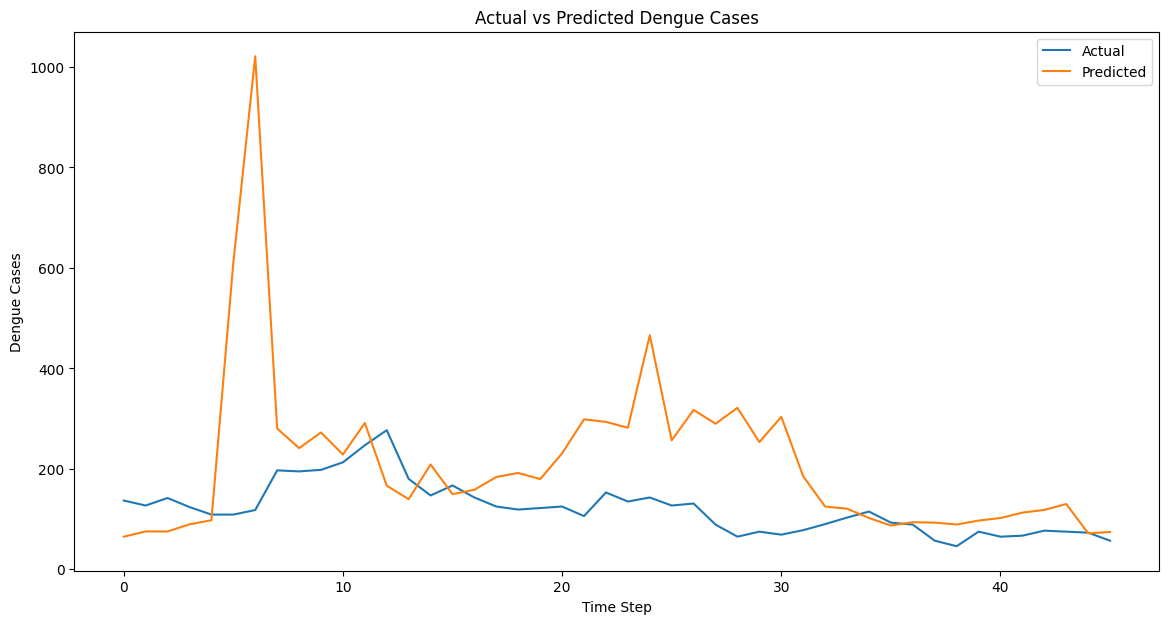

In [ ]:
# Compare the predictions with the actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_target_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Dengue Cases')
plt.title('Actual vs Predicted Dengue Cases')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the dengue and climate data
dengue_file_path = 'dengue_am.csv'
climate_file_path = 'climate_am.csv'

dengue_data = pd.read_csv(dengue_file_path)
climate_data = pd.read_csv(climate_file_path)

# Filter for train_1 == True and target_1 == True
dengue_data['train_1'] = dengue_data['train_1'].astype(bool)
dengue_data['target_1'] = dengue_data['target_1'].astype(bool)

dengue_train = dengue_data[dengue_data['train_1']]
dengue_target = dengue_data[dengue_data['target_1']]

# Convert date columns to datetime
dengue_train['date'] = pd.to_datetime(dengue_train['date'])
dengue_target['date'] = pd.to_datetime(dengue_target['date'])
climate_data['date'] = pd.to_datetime(climate_data['date'])

# Merge the datasets on 'date'
train_data = pd.merge(dengue_train, climate_data, on='date')
target_data = pd.merge(dengue_target, climate_data, on='date')

# Select relevant columns excluding 'epiweek'
columns_to_keep = ['date', 'casos', 'temp_min', 'temp_med', 'temp_max',
                   'precip_min', 'precip_med', 'precip_max', 'precip_tot',
                   'pressure_min', 'pressure_med', 'pressure_max',
                   'rel_humid_min', 'rel_humid_med', 'rel_humid_max',
                   'thermal_range', 'rainy_days']

train_data = train_data[columns_to_keep]
target_data = target_data[columns_to_keep]

# Separate the target variable and climate features excluding 'date'
X_train_climate = train_data.drop(columns=['casos', 'date'])
X_target_climate = target_data.drop(columns=['casos', 'date'])

# Standardize the climate features
scaler_climate = StandardScaler()
X_train_climate_scaled = scaler_climate.fit_transform(X_train_climate)
X_target_climate_scaled = scaler_climate.transform(X_target_climate)

# Scale the 'casos' column separately
scaler_casos = MinMaxScaler()
train_data['casos_scaled'] = scaler_casos.fit_transform(train_data[['casos']])
target_data['casos_scaled'] = scaler_casos.transform(target_data[['casos']])

# Apply PCA to climate features
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_climate_scaled)
X_target_pca = pca.transform(X_target_climate_scaled)

# Create DataFrames with PCA components
n_components = X_train_pca.shape[1]
train_pca_df = pd.DataFrame(X_train_pca, index=train_data.index, columns=[f'PC{i+1}' for i in range(n_components)])
target_pca_df = pd.DataFrame(X_target_pca, index=target_data.index, columns=[f'PC{i+1}' for i in range(n_components)])

# Add the scaled target variable 'casos_scaled' and 'date' to the PCA DataFrames
train_pca_df['casos_scaled'] = train_data['casos_scaled']
train_pca_df['date'] = train_data.index
target_pca_df['casos_scaled'] = target_data['casos_scaled']
target_pca_df['date'] = target_data.index

# Set date as index
train_pca_df.set_index('date', inplace=True)
target_pca_df.set_index('date', inplace=True)

# Prepare the data for LSTM with PCA components
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps, :-1])  # Features (exclude 'casos_scaled')
        y.append(data[i + n_steps, -1])  # Target ('casos_scaled')
    return np.array(X), np.array(y)

n_steps = 5
X_train, y_train = create_sequences(train_pca_df.values, n_steps)
X_target, y_target = create_sequences(target_pca_df.values, n_steps)

# Define the LSTM model
model = Sequential()
model.add(LSTM(1000, activation='relu', return_sequences=True, input_shape=(n_steps, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=500, verbose=1)

# Make predictions
y_pred = model.predict(X_target)

# Inverse transform the predictions
y_pred_inv = scaler_casos.inverse_transform(y_pred.reshape(-1, 1))

# Inverse transform the actual values
y_target_inv = scaler_casos.inverse_transform(y_target.reshape(-1, 1))

# Flatten the arrays for easy comparison
y_pred_inv = y_pred_inv.flatten()
y_target_inv = y_target_inv.flatten()

# Print or return the real cases
print("Real Cases (Actual):", y_target_inv)
print("Real Cases (Predicted):", y_pred_inv)

# Calculate MAE and MAPE
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_target_inv, y_pred_inv)
mape = np.mean(np.abs((y_target_inv - y_pred_inv) / y_target_inv)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


<ipython-input-53-2868000aeb69>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-53-2868000aeb69>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Epoch 1/500
21/21 [==============================] - 3s 20ms/step - loss: 0.0098
Epoch 2/500
21/21 [==============================] - 0s 20ms/step - loss: 0.0061
Epoch 3/500
21/21 [==============================] - 0s 19ms/step - loss: 0.0054
Epoch 4/500
21/21 [==============================] - 0s 20ms/step - loss: 0.0045
Epoch 5/500
21/21 [==============================] - 0s 19ms/step - loss: 0.0040
Epoch 6/500
21/21 [==============================] - 0s 19ms/step - loss: 0.0042
Epoch 7/500
21/21 [==============================] - 0s 19ms/step - loss: 0.0031
Epoch 8/500
21/21 [==============================] - 0s 20ms/step - loss: 0.0035
Epoch 9/500
21/21 [==============================] - 0s 19ms/step - loss: 0.0029
Epoch 10/500
21/21 [==============================] - 0s 19ms/step - loss: 0.0025
Epoch 11/500
21/21 [==============================] - 0s 19ms/step - loss: 0.0039
Epoch 12/500
21/21 [==============================] - 0s 23ms/step - loss: 0.0047
Epoch 13/500
21/21 [=====

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error


dengue_data = pd.read_csv(dengue_file_path)
climate_data = pd.read_csv(climate_file_path)

# Filter for train_1 == True and target_1 == True
dengue_data['train_1'] = dengue_data['train_1'].astype(bool)
dengue_data['target_1'] = dengue_data['target_1'].astype(bool)

dengue_train = dengue_data[dengue_data['train_1']]
dengue_target = dengue_data[dengue_data['target_1']]

# Convert date columns to datetime
dengue_train['date'] = pd.to_datetime(dengue_train['date'])
dengue_target['date'] = pd.to_datetime(dengue_target['date'])
climate_data['date'] = pd.to_datetime(climate_data['date'])

# Merge the datasets on 'date'
train_data = pd.merge(dengue_train, climate_data, on='date')
target_data = pd.merge(dengue_target, climate_data, on='date')

# Select relevant columns excluding 'epiweek'
columns_to_keep = ['date', 'casos', 'temp_min', 'temp_med', 'temp_max',
                   'precip_min', 'precip_med', 'precip_max', 'precip_tot',
                   'pressure_min', 'pressure_med', 'pressure_max',
                   'rel_humid_min', 'rel_humid_med', 'rel_humid_max',
                   'thermal_range', 'rainy_days']

train_data = train_data[columns_to_keep]
target_data = target_data[columns_to_keep]

# Apply Variance Threshold
climate_features = train_data.drop(columns=['casos', 'date'])
selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(climate_features)

# Get the selected feature names
selected_feature_names = climate_features.columns[selector.get_support()]
selected_feature_names = list(selected_feature_names)
print("Selected Features:", selected_feature_names)

# Add 'casos' and 'date' to the selected features
selected_feature_names = ['casos', 'date'] + selected_feature_names

# Update train_data and target_data with selected features
train_data = train_data[selected_feature_names]
target_data = target_data[selected_feature_names]

# Separate the target variable and climate features excluding 'date'
X_train_climate = train_data.drop(columns=['casos', 'date'])
X_target_climate = target_data.drop(columns=['casos', 'date'])

# Standardize the climate features
scaler_climate = StandardScaler()
X_train_climate_scaled = scaler_climate.fit_transform(X_train_climate)
X_target_climate_scaled = scaler_climate.transform(X_target_climate)

# Scale the 'casos' column separately
scaler_casos = MinMaxScaler()
train_data['casos_scaled'] = scaler_casos.fit_transform(train_data[['casos']])
target_data['casos_scaled'] = scaler_casos.transform(target_data[['casos']])

# Apply PCA to climate features
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_climate_scaled)
X_target_pca = pca.transform(X_target_climate_scaled)

# Create DataFrames with PCA components
n_components = X_train_pca.shape[1]
train_pca_df = pd.DataFrame(X_train_pca, index=train_data.index, columns=[f'PC{i+1}' for i in range(n_components)])
target_pca_df = pd.DataFrame(X_target_pca, index=target_data.index, columns=[f'PC{i+1}' for i in range(n_components)])

# Add the scaled target variable 'casos_scaled' and 'date' to the PCA DataFrames
train_pca_df['casos_scaled'] = train_data['casos_scaled']
train_pca_df['date'] = train_data['date']
target_pca_df['casos_scaled'] = target_data['casos_scaled']
target_pca_df['date'] = target_data['date']

# Set date as index
train_pca_df.set_index('date', inplace=True)
target_pca_df.set_index('date', inplace=True)

# Prepare the data for LSTM with PCA components
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps, :-1])  # Features (exclude 'casos_scaled')
        y.append(data[i + n_steps, -1])  # Target ('casos_scaled')
    return np.array(X), np.array(y)

n_steps = 5
X_train, y_train = create_sequences(train_pca_df.values, n_steps)
X_target, y_target = create_sequences(target_pca_df.values, n_steps)

# Define the LSTM model
model = Sequential()
model.add(LSTM(1000, activation='relu', return_sequences=True, input_shape=(n_steps, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=500, verbose=1)

# Make predictions
y_pred = model.predict(X_target)

# Inverse transform the predictions
y_pred_inv = scaler_casos.inverse_transform(y_pred.reshape(-1, 1))

# Inverse transform the actual values
y_target_inv = scaler_casos.inverse_transform(y_target.reshape(-1, 1))

# Flatten the arrays for easy comparison
y_pred_inv = y_pred_inv.flatten()
y_target_inv = y_target_inv.flatten()

# Print or return the real cases
print("Real Cases (Actual):", y_target_inv)
print("Real Cases (Predicted):", y_pred_inv)

# Calculate MAE and MAPE
mae = mean_absolute_error(y_target_inv, y_pred_inv)
mape = np.mean(np.abs((y_target_inv - y_pred_inv) / y_target_inv)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


<ipython-input-55-c71126313d9e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-55-c71126313d9e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Selected Features: ['temp_min', 'temp_med', 'temp_max', 'precip_max', 'precip_tot', 'rel_humid_min', 'rel_humid_med', 'rel_humid_max', 'thermal_range', 'rainy_days']


Epoch 1/500
21/21 [==============================] - 4s 20ms/step - loss: 0.0100
Epoch 2/500
21/21 [==============================] - 0s 21ms/step - loss: 0.0072
Epoch 3/500
21/21 [==============================] - 1s 32ms/step - loss: 0.0072
Epoch 4/500
21/21 [==============================] - 1s 34ms/step - loss: 0.0070
Epoch 5/500
21/21 [==============================] - 1s 35ms/step - loss: 0.0070
Epoch 6/500
21/21 [==============================] - 1s 35ms/step - loss: 0.0070
Epoch 7/500
21/21 [==============================] - 0s 20ms/step - loss: 0.0067
Epoch 8/500
21/21 [==============================] - 0s 19ms/step - loss: 0.0067
Epoch 9/500
21/21 [==============================] - 0s 20ms/step - loss: 0.0067
Epoch 10/500
21/21 [==============================] - 0s 19ms/step - loss: 0.0067
Epoch 11/500
21/21 [==============================] - 0s 20ms/step - loss: 0.0059
Epoch 12/500
21/21 [==============================] - 0s 20ms/step - loss: 0.0057
Epoch 13/500
21/21 [=====

In [ ]:

print(len(y_pred_inv))
print(len(y_target_inv))
print(len(target_pca_df.index))

46
46
51


In [ ]:
import numpy as np

def create_sequences(data, n_steps):
    X, y, indices = [], [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps, :-1])  # Features (exclude 'casos_scaled')
        y.append(data[i + n_steps, -1])  # Target ('casos_scaled')
        indices.append(i + n_steps)  # Track the indices used for y
    return np.array(X), np.array(y), indices

n_steps = 5  # Define the sequence length

# Create sequences from the PCA-transformed data
X_train, y_train, train_indices = create_sequences(train_pca_df.values, n_steps)
X_target, y_target, target_indices = create_sequences(target_pca_df.values, n_steps)

print(f"Length of X_target: {len(X_target)}")
print(f"Length of y_target: {len(y_target)}")
print(f"Length of target_indices: {len(target_indices)}")



Length of X_target: 46
Length of y_target: 46
Length of target_indices: 46


In [ ]:
len(y_target_inv)

46

In [ ]:
len(y_pred_inv)

51

In [ ]:
len(y_target_inv)

51

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error

# Load data
dengue_file_path = 'dengue_am.csv'
climate_file_path = 'climate_am.csv'
dengue_data = pd.read_csv(dengue_file_path)
climate_data = pd.read_csv(climate_file_path)

# Filter for train_1 == True and target_1 == True
dengue_data['train_1'] = dengue_data['train_1'].astype(bool)
dengue_data['target_1'] = dengue_data['target_1'].astype(bool)

dengue_train = dengue_data[dengue_data['train_1']]
dengue_target = dengue_data[dengue_data['target_1']]

# Convert date columns to datetime
dengue_train['date'] = pd.to_datetime(dengue_train['date'])
dengue_target['date'] = pd.to_datetime(dengue_target['date'])
climate_data['date'] = pd.to_datetime(climate_data['date'])

# Merge the datasets on 'date'
train_data = pd.merge(dengue_train, climate_data, on='date')
target_data = pd.merge(dengue_target, climate_data, on='date')

# Select relevant columns excluding 'epiweek'
columns_to_keep = ['date', 'casos', 'temp_min', 'temp_med', 'temp_max',
                   'precip_min', 'precip_med', 'precip_max', 'precip_tot',
                   'pressure_min', 'pressure_med', 'pressure_max',
                   'rel_humid_min', 'rel_humid_med', 'rel_humid_max',
                   'thermal_range', 'rainy_days']

train_data = train_data[columns_to_keep]
target_data = target_data[columns_to_keep]

# Apply Variance Threshold
climate_features = train_data.drop(columns=['casos', 'date'])
selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(climate_features)

# Get the selected feature names
selected_feature_names = climate_features.columns[selector.get_support()]
selected_feature_names = list(selected_feature_names)
print("Selected Features:", selected_feature_names)

# Add 'casos' and 'date' to the selected features
selected_feature_names = ['casos', 'date'] + selected_feature_names

# Update train_data and target_data with selected features
train_data = train_data[selected_feature_names]
target_data = target_data[selected_feature_names]

# Separate the target variable and climate features excluding 'date'
X_train_climate = train_data.drop(columns=['casos', 'date'])
X_target_climate = target_data.drop(columns=['casos', 'date'])

# Standardize the climate features
scaler_climate = StandardScaler()
X_train_climate_scaled = scaler_climate.fit_transform(X_train_climate)
X_target_climate_scaled = scaler_climate.transform(X_target_climate)

# Scale the 'casos' column separately
scaler_casos = MinMaxScaler()
train_data['casos_scaled'] = scaler_casos.fit_transform(train_data[['casos']])
target_data['casos_scaled'] = scaler_casos.transform(target_data[['casos']])

# Apply PCA to climate features
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_climate_scaled)
X_target_pca = pca.transform(X_target_climate_scaled)

# Create DataFrames with PCA components
n_components = X_train_pca.shape[1]
train_pca_df = pd.DataFrame(X_train_pca, index=train_data.index, columns=[f'PC{i+1}' for i in range(n_components)])
target_pca_df = pd.DataFrame(X_target_pca, index=target_data.index, columns=[f'PC{i+1}' for i in range(n_components)])

# Add the scaled target variable 'casos_scaled' and 'date' to the PCA DataFrames
train_pca_df['casos_scaled'] = train_data['casos_scaled']
train_pca_df['date'] = train_data['date']
target_pca_df['casos_scaled'] = target_data['casos_scaled']
target_pca_df['date'] = target_data['date']

# Set date as index
train_pca_df.set_index('date', inplace=True)
target_pca_df.set_index('date', inplace=True)

# Prepare the data for LSTM without sequences
X_train = train_pca_df.drop(columns=['casos_scaled']).values
y_train = train_pca_df['casos_scaled'].values
X_target = target_pca_df.drop(columns=['casos_scaled']).values

# Define the LSTM model
model = Sequential()
model.add(LSTM(1000, activation='relu', input_shape=(1, X_train.shape[1])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Reshape the data for LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_target_reshaped = X_target.reshape((X_target.shape[0], 1, X_target.shape[1]))

# Train the model
model.fit(X_train_reshaped, y_train, epochs=50, verbose=1)

# Make predictions
y_pred = model.predict(X_target_reshaped)

# Inverse transform the predictions
y_pred_inv = scaler_casos.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Inverse transform the actual values
y_target_inv = scaler_casos.inverse_transform(target_data['casos_scaled'].values.reshape(-1, 1)).flatten()

# Print or return the real cases
print("Real Cases (Actual):", y_target_inv)
print("Real Cases (Predicted):", y_pred_inv)

# Calculate MAE and MAPE
mae = mean_absolute_error(y_target_inv, y_pred_inv)
mape = np.mean(np.abs((y_target_inv - y_pred_inv) / y_target_inv)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


<ipython-input-17-0a15c9f2b425>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-17-0a15c9f2b425>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Selected Features: ['temp_min', 'temp_med', 'temp_max', 'precip_max', 'precip_tot', 'rel_humid_min', 'rel_humid_med', 'rel_humid_max', 'thermal_range', 'rainy_days']
Epoch 1/50
21/21 [==============================] - 4s 6ms/step - loss: 0.0078
Epoch 2/50
21/21 [==============================] - 0s 9ms/step - loss: 0.0076
Epoch 3/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0074
Epoch 4/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0074
Epoch 5/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0073
Epoch 6/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0074
Epoch 7/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0072
Epoch 8/50
21/21 [==============================] - 0s 10ms/step - loss: 0.0072
Epoch 9/50
21/21 [==============================] - 0s 9ms/step - loss: 0.0078
Epoch 10/50
21/21 [==============================] - 0s 9ms/step - loss: 0.0073
Epoch 11/50
21/21 [=======================

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error

# Load data
dengue_file_path = 'dengue_am.csv'
climate_file_path = 'climate_am.csv'
dengue_data = pd.read_csv(dengue_file_path)
climate_data = pd.read_csv(climate_file_path)

# Filter for train_1 == True and target_1 == True
dengue_data['train_1'] = dengue_data['train_1'].astype(bool)
dengue_data['target_1'] = dengue_data['target_1'].astype(bool)

dengue_train = dengue_data[dengue_data['train_1']]
dengue_target = dengue_data[dengue_data['target_1']]

# Convert date columns to datetime
dengue_train['date'] = pd.to_datetime(dengue_train['date'])
dengue_target['date'] = pd.to_datetime(dengue_target['date'])
climate_data['date'] = pd.to_datetime(climate_data['date'])

# Merge the datasets on 'date'
train_data = pd.merge(dengue_train, climate_data, on='date')
target_data = pd.merge(dengue_target, climate_data, on='date')

# Select relevant columns excluding 'epiweek'
columns_to_keep = ['date', 'casos', 'temp_min', 'temp_med', 'temp_max',
                   'precip_min', 'precip_med', 'precip_max', 'precip_tot',
                   'pressure_min', 'pressure_med', 'pressure_max',
                   'rel_humid_min', 'rel_humid_med', 'rel_humid_max',
                   'thermal_range', 'rainy_days']

train_data = train_data[columns_to_keep]
target_data = target_data[columns_to_keep]

# Apply Variance Threshold
climate_features = train_data.drop(columns=['casos', 'date'])
selector = VarianceThreshold(threshold=0.08)
selected_features = selector.fit_transform(climate_features)

# Get the selected feature names
selected_feature_names = climate_features.columns[selector.get_support()]
selected_feature_names = list(selected_feature_names)
print("Selected Features:", selected_feature_names)

# Add 'casos' and 'date' to the selected features
selected_feature_names = ['casos', 'date'] + selected_feature_names

# Update train_data and target_data with selected features
train_data = train_data[selected_feature_names]
target_data = target_data[selected_feature_names]

# Separate the target variable and climate features excluding 'date'
X_train_climate = train_data.drop(columns=['casos', 'date'])
X_target_climate = target_data.drop(columns=['casos', 'date'])

# Standardize the climate features
scaler_climate = StandardScaler()
X_train_climate_scaled = scaler_climate.fit_transform(X_train_climate)
X_target_climate_scaled = scaler_climate.transform(X_target_climate)

# Scale the 'casos' column separately
scaler_casos = MinMaxScaler()
train_data['casos_scaled'] = scaler_casos.fit_transform(train_data[['casos']])
target_data['casos_scaled'] = scaler_casos.transform(target_data[['casos']])

# Apply PCA to climate features
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_climate_scaled)
X_target_pca = pca.transform(X_target_climate_scaled)

# Create DataFrames with PCA components
n_components = X_train_pca.shape[1]
train_pca_df = pd.DataFrame(X_train_pca, index=train_data.index, columns=[f'PC{i+1}' for i in range(n_components)])
target_pca_df = pd.DataFrame(X_target_pca, index=target_data.index, columns=[f'PC{i+1}' for i in range(n_components)])

# Add the scaled target variable 'casos_scaled' and 'date' to the PCA DataFrames
train_pca_df['casos_scaled'] = train_data['casos_scaled']
train_pca_df['date'] = train_data['date']
target_pca_df['casos_scaled'] = target_data['casos_scaled']
target_pca_df['date'] = target_data['date']

# Set date as index
train_pca_df.set_index('date', inplace=True)
target_pca_df.set_index('date', inplace=True)

# Prepare the data for LSTM
X_train = train_pca_df.drop(columns=['casos_scaled']).values
y_train = train_pca_df['casos_scaled'].values
X_target = target_pca_df.drop(columns=['casos_scaled']).values


# Define a more complex LSTM model
model = Sequential()
model.add(LSTM(1000, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])))
model.add(Dropout(0.3))
model.add(LSTM(500, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(250, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Reshape the data for LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_target_reshaped = X_target.reshape((X_target.shape[0], 1, X_target.shape[1]))

# Train the model
model.fit(X_train_reshaped, y_train, epochs=500, batch_size=32, verbose=1)

# Make predictions
y_pred = model.predict(X_target_reshaped)

# Inverse transform the predictions
y_pred_inv = scaler_casos.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Inverse transform the actual values
y_target_inv = scaler_casos.inverse_transform(target_data['casos_scaled'].values.reshape(-1, 1)).flatten()

# Set values less than 0 to 0
y_target_inv[y_target_inv < 0] = 0

# Print or return the real cases
print("Real Cases (Actual):", y_target_inv)
print("Real Cases (Predicted):", y_pred_inv)

# Calculate MAE and MAPE
mae = mean_absolute_error(y_target_inv, y_pred_inv)
mape = np.mean(np.abs((y_target_inv - y_pred_inv) / y_target_inv)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


<ipython-input-31-9fbfa99440ed>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-31-9fbfa99440ed>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Selected Features: ['temp_min', 'temp_med', 'temp_max', 'precip_max', 'precip_tot', 'rel_humid_min', 'rel_humid_med', 'rel_humid_max', 'thermal_range', 'rainy_days']


Epoch 1/500
21/21 [==============================] - 12s 14ms/step - loss: 0.0079
Epoch 2/500
21/21 [==============================] - 0s 14ms/step - loss: 0.0077
Epoch 3/500
21/21 [==============================] - 0s 13ms/step - loss: 0.0074
Epoch 4/500
21/21 [==============================] - 0s 15ms/step - loss: 0.0072
Epoch 5/500
21/21 [==============================] - 0s 13ms/step - loss: 0.0076
Epoch 6/500
21/21 [==============================] - 0s 13ms/step - loss: 0.0073
Epoch 7/500
21/21 [==============================] - 0s 14ms/step - loss: 0.0072
Epoch 8/500
21/21 [==============================] - 0s 14ms/step - loss: 0.0073
Epoch 9/500
21/21 [==============================] - 0s 14ms/step - loss: 0.0073
Epoch 10/500
21/21 [==============================] - 0s 14ms/step - loss: 0.0073
Epoch 11/500
21/21 [==============================] - 0s 14ms/step - loss: 0.0071
Epoch 12/500
21/21 [==============================] - 0s 14ms/step - loss: 0.0071
Epoch 13/500
21/21 [====

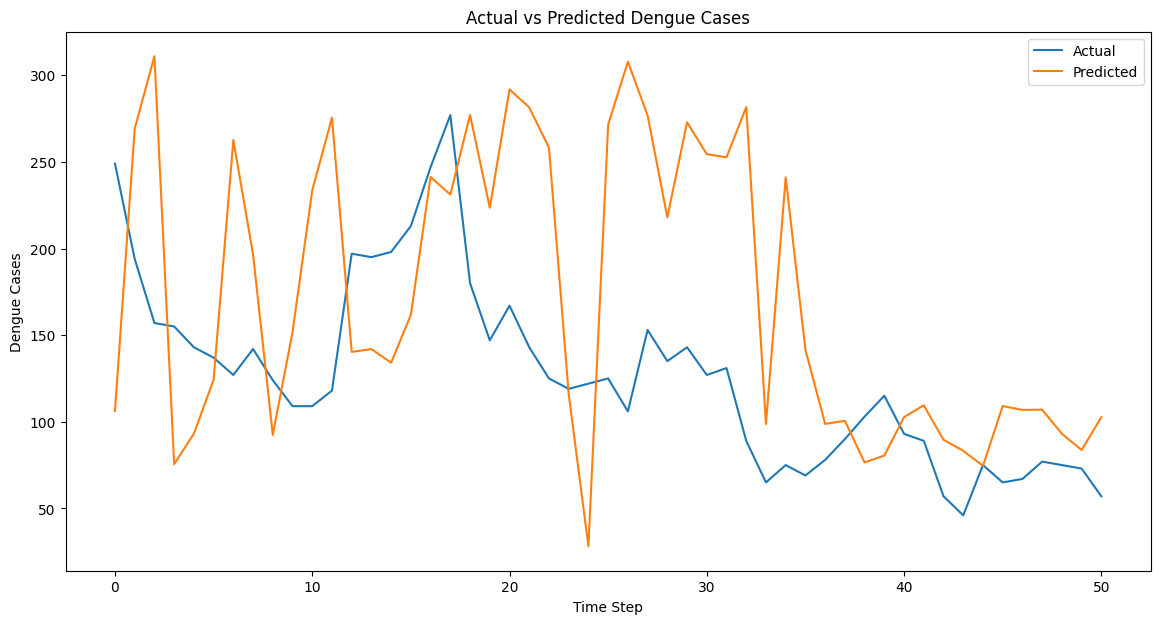

In [ ]:
# Compare the predictions with the actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_target_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Dengue Cases')
plt.title('Actual vs Predicted Dengue Cases')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

# Load data
dengue_file_path = 'dengue_am.csv'
climate_file_path = 'climate_am.csv'
dengue_data = pd.read_csv(dengue_file_path)
climate_data = pd.read_csv(climate_file_path)

# Filter for train_1 == True and target_1 == True
dengue_data['train_1'] = dengue_data['train_1'].astype(bool)
dengue_data['target_1'] = dengue_data['target_1'].astype(bool)

dengue_train = dengue_data[dengue_data['train_1']]
dengue_target = dengue_data[dengue_data['target_1']]

# Convert date columns to datetime
dengue_train['date'] = pd.to_datetime(dengue_train['date'])
dengue_target['date'] = pd.to_datetime(dengue_target['date'])
climate_data['date'] = pd.to_datetime(climate_data['date'])

# Merge the datasets on 'date'
train_data = pd.merge(dengue_train, climate_data, on='date')
target_data = pd.merge(dengue_target, climate_data, on='date')

# Select relevant columns excluding 'epiweek'
columns_to_keep = ['date', 'casos', 'temp_min', 'temp_med', 'temp_max',
                   'precip_min', 'precip_med', 'precip_max', 'precip_tot',
                   'pressure_min', 'pressure_med', 'pressure_max',
                   'rel_humid_min', 'rel_humid_med', 'rel_humid_max',
                   'thermal_range', 'rainy_days']

train_data = train_data[columns_to_keep]
target_data = target_data[columns_to_keep]

# Apply Variance Threshold
climate_features = train_data.drop(columns=['casos', 'date'])
selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(climate_features)

# Get the selected feature names
selected_feature_names = climate_features.columns[selector.get_support()]
selected_feature_names = list(selected_feature_names)
print("Selected Features:", selected_feature_names)

# Add 'casos' and 'date' to the selected features
selected_feature_names = ['casos', 'date'] + selected_feature_names

# Update train_data and target_data with selected features
train_data = train_data[selected_feature_names]
target_data = target_data[selected_feature_names]

# Separate the target variable and climate features excluding 'date'
X_train_climate = train_data.drop(columns=['casos', 'date'])
X_target_climate = target_data.drop(columns=['casos', 'date'])

# Standardize the climate features
scaler_climate = StandardScaler()
X_train_climate_scaled = scaler_climate.fit_transform(X_train_climate)
X_target_climate_scaled = scaler_climate.transform(X_target_climate)

# Scale the 'casos' column separately
scaler_casos = MinMaxScaler()
train_data['casos_scaled'] = scaler_casos.fit_transform(train_data[['casos']])
target_data['casos_scaled'] = scaler_casos.transform(target_data[['casos']])

# Apply PCA to climate features
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_climate_scaled)
X_target_pca = pca.transform(X_target_climate_scaled)

# Create DataFrames with PCA components
n_components = X_train_pca.shape[1]
train_pca_df = pd.DataFrame(X_train_pca, index=train_data.index, columns=[f'PC{i+1}' for i in range(n_components)])
target_pca_df = pd.DataFrame(X_target_pca, index=target_data.index, columns=[f'PC{i+1}' for i in range(n_components)])

# Add the scaled target variable 'casos_scaled' and 'date' to the PCA DataFrames
train_pca_df['casos_scaled'] = train_data['casos_scaled']
train_pca_df['date'] = train_data['date']
target_pca_df['casos_scaled'] = target_data['casos_scaled']
target_pca_df['date'] = target_data['date']

# Set date as index
train_pca_df.set_index('date', inplace=True)
target_pca_df.set_index('date', inplace=True)

# Prepare the data for the transformer model
X_train = train_pca_df.drop(columns=['casos_scaled']).values
y_train = train_pca_df['casos_scaled'].values
X_target = target_pca_df.drop(columns=['casos_scaled']).values

# Define transformer model
class TransformerModel(tf.keras.Model):
    def __init__(self):
        super(TransformerModel, self).__init__()
        self.attention1 = MultiHeadAttention(num_heads=2, key_dim=2)
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(0.3)
        self.attention2 = MultiHeadAttention(num_heads=2, key_dim=2)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout2 = Dropout(0.3)
        self.dense1 = Dense(50, activation='relu')
        self.dense2 = Dense(1)

    def call(self, inputs):
        x = self.attention1(inputs, inputs)
        x = self.norm1(x)
        x = self.dropout1(x)
        x = self.attention2(x, x)
        x = self.norm2(x)
        x = self.dropout2(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

model = TransformerModel()
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

# Reshape the data for transformer input
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_target_reshaped = X_target.reshape((X_target.shape[0], 1, X_target.shape[1]))

# Train the model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions
y_pred = model.predict(X_target_reshaped)

# Inverse transform the predictions
y_pred_inv = scaler_casos.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Inverse transform the actual values
y_target_inv = scaler_casos.inverse_transform(target_data['casos_scaled'].values.reshape(-1, 1)).flatten()

# Set values less than 0 to 0
y_pred_inv[y_pred_inv < 0] = 0

# Print or return the real cases
print("Real Cases (Actual):", y_target_inv)
print("Real Cases (Predicted):", y_pred_inv)

# Calculate MAE and MAPE
mae = mean_absolute_error(y_target_inv, y_pred_inv)
mape = np.mean(np.abs((y_target_inv - y_pred_inv) / y_target_inv)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


<ipython-input-34-15f3347c365c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-34-15f3347c365c>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Selected Features: ['temp_min', 'temp_med', 'temp_max', 'precip_max', 'precip_tot', 'rel_humid_min', 'rel_humid_med', 'rel_humid_max', 'thermal_range', 'rainy_days']
Epoch 1/100
21/21 [==============================] - 7s 13ms/step - loss: 0.2192
Epoch 2/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0602
Epoch 3/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0305
Epoch 4/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0231
Epoch 5/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0161
Epoch 6/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0144
Epoch 7/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0134
Epoch 8/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0119
Epoch 9/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0115
Epoch 10/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0112
Epoch 11/100
21/21 [===

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Load data
dengue_file_path = 'dengue_am.csv'
climate_file_path = 'climate_am.csv'
dengue_data = pd.read_csv(dengue_file_path)
climate_data = pd.read_csv(climate_file_path)

# Filter for train_1 == True and target_1 == True
dengue_data['train_1'] = dengue_data['train_1'].astype(bool)
dengue_data['target_1'] = dengue_data['target_1'].astype(bool)

dengue_train = dengue_data[dengue_data['train_1']]
dengue_target = dengue_data[dengue_data['target_1']]

# Convert date columns to datetime
dengue_train['date'] = pd.to_datetime(dengue_train['date'])
dengue_target['date'] = pd.to_datetime(dengue_target['date'])
climate_data['date'] = pd.to_datetime(climate_data['date'])

# Merge the datasets on 'date'
train_data = pd.merge(dengue_train, climate_data, on='date')
target_data = pd.merge(dengue_target, climate_data, on='date')

# Select relevant columns excluding 'epiweek'
columns_to_keep = ['date', 'casos', 'temp_min', 'temp_med', 'temp_max',
                   'precip_min', 'precip_med', 'precip_max', 'precip_tot',
                   'pressure_min', 'pressure_med', 'pressure_max',
                   'rel_humid_min', 'rel_humid_med', 'rel_humid_max',
                   'thermal_range', 'rainy_days']

train_data = train_data[columns_to_keep]
target_data = target_data[columns_to_keep]

# Apply Variance Threshold
climate_features = train_data.drop(columns=['casos', 'date'])
selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(climate_features)

# Get the selected feature names
selected_feature_names = climate_features.columns[selector.get_support()]
selected_feature_names = list(selected_feature_names)
print("Selected Features:", selected_feature_names)

# Add 'casos' and 'date' to the selected features
selected_feature_names = ['casos', 'date'] + selected_feature_names

# Update train_data and target_data with selected features
train_data = train_data[selected_feature_names]
target_data = target_data[selected_feature_names]

# Separate the target variable and climate features excluding 'date'
X_train_climate = train_data.drop(columns=['casos', 'date'])
X_target_climate = target_data.drop(columns=['casos', 'date'])

# Standardize the climate features
scaler_climate = StandardScaler()
X_train_climate_scaled = scaler_climate.fit_transform(X_train_climate)
X_target_climate_scaled = scaler_climate.transform(X_target_climate)

# Scale the 'casos' column separately
scaler_casos = MinMaxScaler()
train_data['casos_scaled'] = scaler_casos.fit_transform(train_data[['casos']])
target_data['casos_scaled'] = scaler_casos.transform(target_data[['casos']])

# Apply PCA to climate features
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_climate_scaled)
X_target_pca = pca.transform(X_target_climate_scaled)

# Create DataFrames with PCA components
n_components = X_train_pca.shape[1]
train_pca_df = pd.DataFrame(X_train_pca, index=train_data.index, columns=[f'PC{i+1}' for i in range(n_components)])
target_pca_df = pd.DataFrame(X_target_pca, index=target_data.index, columns=[f'PC{i+1}' for i in range(n_components)])

# Add the scaled target variable 'casos_scaled' and 'date' to the PCA DataFrames
train_pca_df['casos_scaled'] = train_data['casos_scaled']
train_pca_df['date'] = train_data['date']
target_pca_df['casos_scaled'] = target_data['casos_scaled']
target_pca_df['date'] = target_data['date']

# Set date as index
train_pca_df.set_index('date', inplace=True)
target_pca_df.set_index('date', inplace=True)

# Prepare the data for the GRU model
X_train = train_pca_df.drop(columns=['casos_scaled']).values
y_train = train_pca_df['casos_scaled'].values
X_target = target_pca_df.drop(columns=['casos_scaled']).values

# Define the GRU model
model = Sequential()
model.add(GRU(512, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])))
model.add(Dropout(0.3))
model.add(GRU(256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Reshape the data for GRU input
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_target_reshaped = X_target.reshape((X_target.shape[0], 1, X_target.shape[1]))

# Train the model
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions
y_pred = model.predict(X_target_reshaped)

# Inverse transform the predictions
y_pred_inv = scaler_casos.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Inverse transform the actual values
y_target_inv = scaler_casos.inverse_transform(target_data['casos_scaled'].values.reshape(-1, 1)).flatten()

# Set values less than 0 to 0
y_pred_inv[y_pred_inv < 0] = 0

# Print or return the real cases
print("Real Cases (Actual):", y_target_inv)
print("Real Cases (Predicted):", y_pred_inv)

# Calculate MAE and MAPE
mae = mean_absolute_error(y_target_inv, y_pred_inv)
mape = np.mean(np.abs((y_target_inv - y_pred_inv) / y_target_inv)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


<ipython-input-35-e387edaf3ff4>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-35-e387edaf3ff4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])
<ipython-input-35-e387edaf3ff4>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Selected Features: ['temp_min', 'temp_med', 'temp_max', 'precip_max', 'precip_tot', 'rel_humid_min', 'rel_humid_med', 'rel_humid_max', 'thermal_range', 'rainy_days']


Epoch 1/100
21/21 [==============================] - 10s 32ms/step - loss: 0.0075
Epoch 2/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0075
Epoch 3/100
21/21 [==============================] - 1s 28ms/step - loss: 0.0073
Epoch 4/100
21/21 [==============================] - 1s 34ms/step - loss: 0.0075
Epoch 5/100
21/21 [==============================] - 1s 34ms/step - loss: 0.0074
Epoch 6/100
21/21 [==============================] - 1s 25ms/step - loss: 0.0072
Epoch 7/100
21/21 [==============================] - 1s 24ms/step - loss: 0.0074
Epoch 8/100
21/21 [==============================] - 0s 18ms/step - loss: 0.0070
Epoch 9/100
21/21 [==============================] - 1s 25ms/step - loss: 0.0072
Epoch 10/100
21/21 [==============================] - 0s 15ms/step - loss: 0.0073
Epoch 11/100
21/21 [==============================] - 1s 26ms/step - loss: 0.0072
Epoch 12/100
21/21 [==============================] - 0s 20ms/step - loss: 0.0074
Epoch 13/100
21/21 [====

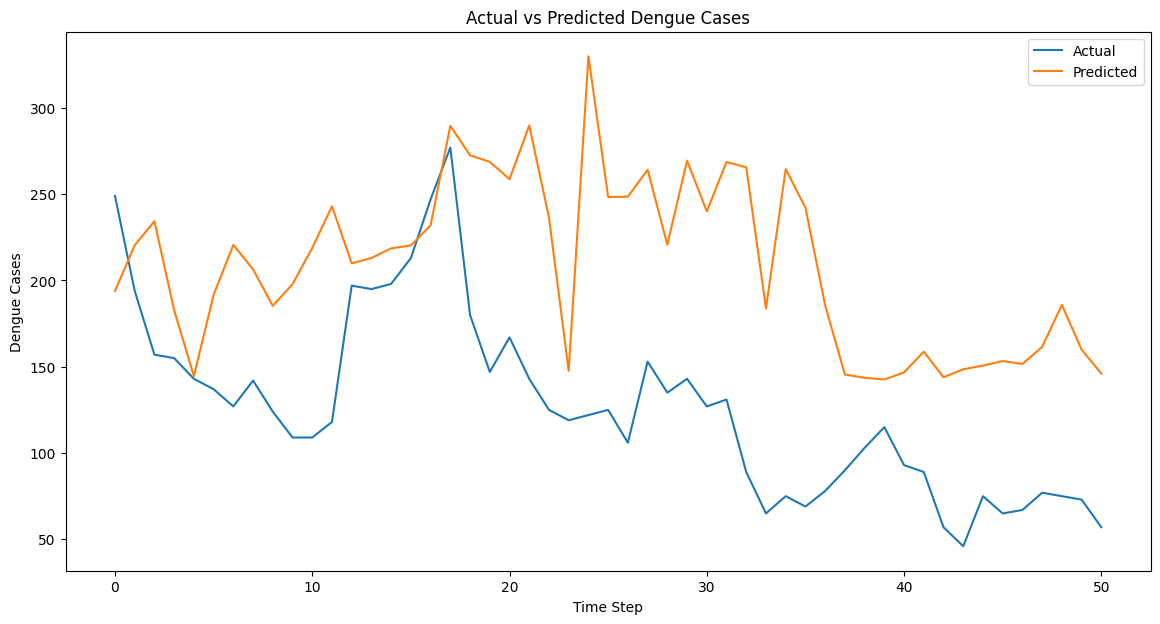

In [ ]:
# Compare the predictions with the actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_target_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Dengue Cases')
plt.title('Actual vs Predicted Dengue Cases')
plt.show()

In [ ]:
# Create a DataFrame with the date, real cases, and predicted cases
results_df = pd.DataFrame({
    'date': target_pca_df.index,
    'real': y_target_inv,
    'predict': y_pred_inv
})

# Save the DataFrame to a CSV file
results_df.to_csv('dengue_prediction_results.csv', index=False)

print("Results saved to 'dengue_prediction_results.csv'")


Results saved to 'dengue_prediction_results.csv'


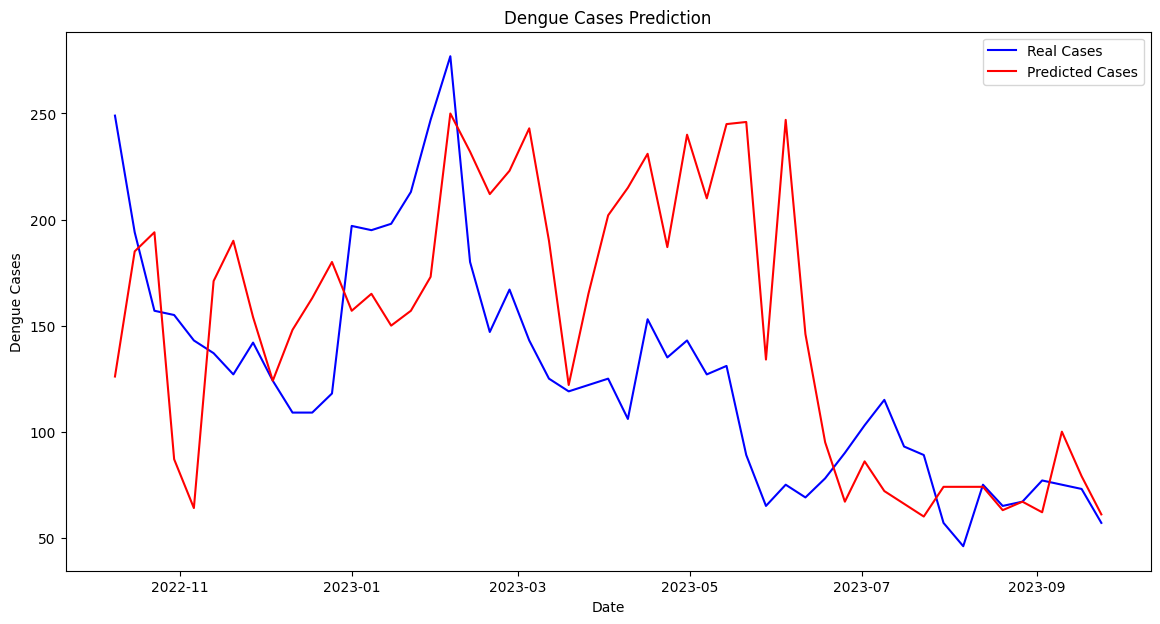

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(results_df['date'], results_df['real'], label='Real Cases', color='blue')
plt.plot(results_df['date'], results_df['predict'], label='Predicted Cases', color='red')
plt.xlabel('Date')
plt.ylabel('Dengue Cases')
plt.title('Dengue Cases Prediction')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error

# Load data
dengue_file_path = 'dengue_am.csv'
climate_file_path = 'climate_am.csv'
dengue_data = pd.read_csv(dengue_file_path)
climate_data = pd.read_csv(climate_file_path)

# Filter for train_1 == True and target_1 == True
dengue_data['train_1'] = dengue_data['train_1'].astype(bool)
dengue_data['target_1'] = dengue_data['target_1'].astype(bool)

dengue_train = dengue_data[dengue_data['train_1']]
dengue_target = dengue_data[dengue_data['target_1']]

# Convert date columns to datetime
dengue_train['date'] = pd.to_datetime(dengue_train['date'])
dengue_target['date'] = pd.to_datetime(dengue_target['date'])
climate_data['date'] = pd.to_datetime(climate_data['date'])

# Merge the datasets on 'date'
train_data = pd.merge(dengue_train, climate_data, on='date')
target_data = pd.merge(dengue_target, climate_data, on='date')

# Select relevant columns excluding 'epiweek'
columns_to_keep = ['date', 'casos', 'temp_min', 'temp_med', 'temp_max',
                   'precip_min', 'precip_med', 'precip_max', 'precip_tot',
                   'pressure_min', 'pressure_med', 'pressure_max',
                   'rel_humid_min', 'rel_humid_med', 'rel_humid_max',
                   'thermal_range', 'rainy_days']

train_data = train_data[columns_to_keep]
target_data = target_data[columns_to_keep]

# Apply Variance Threshold
climate_features = train_data.drop(columns=['casos', 'date'])
selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(climate_features)

# Get the selected feature names
selected_feature_names = climate_features.columns[selector.get_support()]
selected_feature_names = list(selected_feature_names)
print("Selected Features:", selected_feature_names)

# Add 'casos' and 'date' to the selected features
selected_feature_names = ['casos', 'date'] + selected_feature_names

# Update train_data and target_data with selected features
train_data = train_data[selected_feature_names]
target_data = target_data[selected_feature_names]

# Separate the target variable and climate features excluding 'date'
X_train_climate = train_data.drop(columns=['casos', 'date'])
X_target_climate = target_data.drop(columns=['casos', 'date'])

# Standardize the climate features
scaler_climate = StandardScaler()
X_train_climate_scaled = scaler_climate.fit_transform(X_train_climate)
X_target_climate_scaled = scaler_climate.transform(X_target_climate)

# Scale the 'casos' column separately
scaler_casos = MinMaxScaler()
train_data['casos_scaled'] = scaler_casos.fit_transform(train_data[['casos']])
target_data['casos_scaled'] = scaler_casos.transform(target_data[['casos']])

# Apply PCA to climate features
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_climate_scaled)
X_target_pca = pca.transform(X_target_climate_scaled)

# Create DataFrames with PCA components
n_components = X_train_pca.shape[1]
train_pca_df = pd.DataFrame(X_train_pca, index=train_data.index, columns=[f'PC{i+1}' for i in range(n_components)])
target_pca_df = pd.DataFrame(X_target_pca, index=target_data.index, columns=[f'PC{i+1}' for i in range(n_components)])

# Add the scaled target variable 'casos_scaled' and 'date' to the PCA DataFrames
train_pca_df['casos_scaled'] = train_data['casos_scaled']
train_pca_df['date'] = train_data['date']
target_pca_df['casos_scaled'] = target_data['casos_scaled']
target_pca_df['date'] = target_data['date']

# Set date as index
train_pca_df.set_index('date', inplace=True)
target_pca_df.set_index('date', inplace=True)

# Prepare the data for LSTM
X_train = train_pca_df.drop(columns=['casos_scaled']).values
y_train = train_pca_df['casos_scaled'].values
X_target = target_pca_df.drop(columns=['casos_scaled']).values


# Define a more complex LSTM model
model = Sequential()
model.add(LSTM(1000, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])))
model.add(Dropout(0.3))
model.add(LSTM(500, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(250, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Reshape the data for LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_target_reshaped = X_target.reshape((X_target.shape[0], 1, X_target.shape[1]))

# Train the model
#model.fit(X_train_reshaped, y_train, epochs=50, batch_size=16, verbose=1)
model.fit(X_train_reshaped, y_train, epochs=100, verbose=1)


# Make predictions
y_pred = model.predict(X_target_reshaped)

# Inverse transform the predictions
y_pred_inv = scaler_casos.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Set values less than 0 to 0
y_pred_inv[y_pred_inv < 0] = 0
# Convert the predictions to integers
y_pred_inv = y_pred_inv.astype(int)

# Inverse transform the actual values
y_target_inv = scaler_casos.inverse_transform(target_data['casos_scaled'].values.reshape(-1, 1)).flatten()


# Print or return the real cases
print("Real Cases (Actual):", y_target_inv)
print("Real Cases (Predicted):", y_pred_inv)

# Calculate MAE and MAPE
mae = mean_absolute_error(y_target_inv, y_pred_inv)
mape = np.mean(np.abs((y_target_inv - y_pred_inv) / y_target_inv)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

<ipython-input-48-53a58c5f5511>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-48-53a58c5f5511>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Selected Features: ['temp_min', 'temp_med', 'temp_max', 'precip_max', 'precip_tot', 'rel_humid_min', 'rel_humid_med', 'rel_humid_max', 'thermal_range', 'rainy_days']


Epoch 1/100
21/21 [==============================] - 12s 14ms/step - loss: 0.0079
Epoch 2/100
21/21 [==============================] - 0s 13ms/step - loss: 0.0077
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0075
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0074
Epoch 5/100
21/21 [==============================] - 0s 13ms/step - loss: 0.0074
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0073
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0073
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0073
Epoch 9/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0071
Epoch 10/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0072
Epoch 11/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0071
Epoch 12/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0073
Epoch 13/100
21/21 [====

In [ ]:
# Convert the predictions to integers
y_pred_inv = y_pred_inv.astype(int)

In [ ]:
# Calculate MAE and MAPE
mae = mean_absolute_error(y_target_inv, y_pred_inv)
mape = np.mean(np.abs((y_target_inv - y_pred_inv) / y_target_inv)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Error (MAE): 60.529411764705884
Mean Absolute Percentage Error (MAPE): 60.03711567617982%


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error

# Load data
dengue_file_path = 'dengue_am.csv'
climate_file_path = 'climate_am.csv'
dengue_data = pd.read_csv(dengue_file_path)
climate_data = pd.read_csv(climate_file_path)

# Filter for train_1 == True and target_1 == True
dengue_data['train_2'] = dengue_data['train_2'].astype(bool)
dengue_data['target_2'] = dengue_data['target_2'].astype(bool)

dengue_train = dengue_data[dengue_data['train_2']]
dengue_target = dengue_data[dengue_data['target_2']]

# Convert date columns to datetime
dengue_train['date'] = pd.to_datetime(dengue_train['date'])
dengue_target['date'] = pd.to_datetime(dengue_target['date'])
climate_data['date'] = pd.to_datetime(climate_data['date'])

# Merge the datasets on 'date'
train_data = pd.merge(dengue_train, climate_data, on='date')
target_data = pd.merge(dengue_target, climate_data, on='date')

# Select relevant columns excluding 'epiweek'
columns_to_keep = ['date', 'casos', 'temp_min', 'temp_med', 'temp_max',
                   'precip_min', 'precip_med', 'precip_max', 'precip_tot',
                   'pressure_min', 'pressure_med', 'pressure_max',
                   'rel_humid_min', 'rel_humid_med', 'rel_humid_max',
                   'thermal_range', 'rainy_days']

train_data = train_data[columns_to_keep]
target_data = target_data[columns_to_keep]

# Apply Variance Threshold
climate_features = train_data.drop(columns=['casos', 'date'])
selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(climate_features)

# Get the selected feature names
selected_feature_names = climate_features.columns[selector.get_support()]
selected_feature_names = list(selected_feature_names)
print("Selected Features:", selected_feature_names)

# Add 'casos' and 'date' to the selected features
selected_feature_names = ['casos', 'date'] + selected_feature_names

# Update train_data and target_data with selected features
train_data = train_data[selected_feature_names]
target_data = target_data[selected_feature_names]

# Separate the target variable and climate features excluding 'date'
X_train_climate = train_data.drop(columns=['casos', 'date'])
X_target_climate = target_data.drop(columns=['casos', 'date'])

# Standardize the climate features
scaler_climate = StandardScaler()
X_train_climate_scaled = scaler_climate.fit_transform(X_train_climate)
X_target_climate_scaled = scaler_climate.transform(X_target_climate)

# Scale the 'casos' column separately
scaler_casos = MinMaxScaler()
train_data['casos_scaled'] = scaler_casos.fit_transform(train_data[['casos']])
target_data['casos_scaled'] = scaler_casos.transform(target_data[['casos']])

# Apply PCA to climate features
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_climate_scaled)
X_target_pca = pca.transform(X_target_climate_scaled)

# Create DataFrames with PCA components
n_components = X_train_pca.shape[1]
train_pca_df = pd.DataFrame(X_train_pca, index=train_data.index, columns=[f'PC{i+1}' for i in range(n_components)])
target_pca_df = pd.DataFrame(X_target_pca, index=target_data.index, columns=[f'PC{i+1}' for i in range(n_components)])

# Add the scaled target variable 'casos_scaled' and 'date' to the PCA DataFrames
train_pca_df['casos_scaled'] = train_data['casos_scaled']
train_pca_df['date'] = train_data['date']
target_pca_df['casos_scaled'] = target_data['casos_scaled']
target_pca_df['date'] = target_data['date']

# Set date as index
train_pca_df.set_index('date', inplace=True)
target_pca_df.set_index('date', inplace=True)

# Prepare the data for LSTM
X_train = train_pca_df.drop(columns=['casos_scaled']).values
y_train = train_pca_df['casos_scaled'].values
X_target = target_pca_df.drop(columns=['casos_scaled']).values


# Define a more complex LSTM model
model = Sequential()
model.add(LSTM(1000, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])))
model.add(Dropout(0.3))
model.add(LSTM(500, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(250, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Reshape the data for LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_target_reshaped = X_target.reshape((X_target.shape[0], 1, X_target.shape[1]))

# Train the model
#model.fit(X_train_reshaped, y_train, epochs=50, batch_size=16, verbose=1)
model.fit(X_train_reshaped, y_train, epochs=100, verbose=1)


# Make predictions
y_pred = model.predict(X_target_reshaped)

# Inverse transform the predictions
y_pred_inv = scaler_casos.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Set values less than 0 to 0
y_pred_inv[y_pred_inv < 0] = 0
# Convert the predictions to integers
y_pred_inv = y_pred_inv.astype(int)

# Inverse transform the actual values
y_target_inv = scaler_casos.inverse_transform(target_data['casos_scaled'].values.reshape(-1, 1)).flatten()


# Print or return the real cases
print("Real Cases (Actual):", y_target_inv)
print("Real Cases (Predicted):", y_pred_inv)

# Calculate MAE and MAPE
mae = mean_absolute_error(y_target_inv, y_pred_inv)
mape = np.mean(np.abs((y_target_inv - y_pred_inv) / y_target_inv)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

<ipython-input-51-7f5408fed58f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-51-7f5408fed58f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Selected Features: ['temp_min', 'temp_med', 'temp_max', 'precip_max', 'precip_tot', 'rel_humid_min', 'rel_humid_med', 'rel_humid_max', 'thermal_range', 'rainy_days']


Epoch 1/100
23/23 [==============================] - 7s 14ms/step - loss: 0.0074
Epoch 2/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0071
Epoch 3/100
23/23 [==============================] - 0s 13ms/step - loss: 0.0069
Epoch 4/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0068
Epoch 5/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0068
Epoch 6/100
23/23 [==============================] - 0s 13ms/step - loss: 0.0068
Epoch 7/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0070
Epoch 8/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0067
Epoch 9/100
23/23 [==============================] - 0s 13ms/step - loss: 0.0068
Epoch 10/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0067
Epoch 11/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0067
Epoch 12/100
23/23 [==============================] - 0s 14ms/step - loss: 0.0068
Epoch 13/100
23/23 [=====

In [ ]:
# Create a DataFrame with the date, real cases, and predicted cases
results_df = pd.DataFrame({
    'date': target_pca_df.index,
    'real': y_target_inv,
    'predict': y_pred_inv
})

# Save the DataFrame to a CSV file
results_df.to_csv('am(2).csv', index=False)

print("Results saved")

Results saved


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import os

# List of states and their corresponding file paths
states = ['am', 'ce', 'go', 'mg', 'pr']
climate_files = [f'aggregated_climate_data_{state}.csv' for state in states]
dengue_files = [f'aggregated_dengue_data_{state}.csv' for state in states]

# Function to preprocess data, train model, and return MAPE and results DataFrame
def train_and_evaluate(state, climate_file, dengue_file, train_col, target_col, epochs, batch_size):
    # Load data
    dengue_data = pd.read_csv(dengue_file)
    climate_data = pd.read_csv(climate_file)

    # Filter for train and target columns
    dengue_data[train_col] = dengue_data[train_col].astype(bool)
    dengue_data[target_col] = dengue_data[target_col].astype(bool)

    dengue_train = dengue_data[dengue_data[train_col]]
    dengue_target = dengue_data[dengue_data[target_col]]

    # Convert date columns to datetime
    dengue_train['date'] = pd.to_datetime(dengue_train['date'])
    dengue_target['date'] = pd.to_datetime(dengue_target['date'])
    climate_data['date'] = pd.to_datetime(climate_data['date'])

    # Merge the datasets on 'date'
    train_data = pd.merge(dengue_train, climate_data, on='date')
    target_data = pd.merge(dengue_target, climate_data, on='date')

    # Select relevant columns excluding 'epiweek'
    columns_to_keep = ['date', 'casos', 'temp_min', 'temp_med', 'temp_max',
                       'precip_min', 'precip_med', 'precip_max', 'precip_tot',
                       'pressure_min', 'pressure_med', 'pressure_max',
                       'rel_humid_min', 'rel_humid_med', 'rel_humid_max',
                       'thermal_range', 'rainy_days']

    train_data = train_data[columns_to_keep]
    target_data = target_data[columns_to_keep]

    # Apply Variance Threshold
    climate_features = train_data.drop(columns=['casos', 'date'])
    selector = VarianceThreshold(threshold=0.1)
    selected_features = selector.fit_transform(climate_features)

    # Get the selected feature names
    selected_feature_names = climate_features.columns[selector.get_support()]
    selected_feature_names = list(selected_feature_names)
    print(f"{state.upper()} - Selected Features:", selected_feature_names)

    # Add 'casos' and 'date' to the selected features
    selected_feature_names = ['casos', 'date'] + selected_feature_names

    # Update train_data and target_data with selected features
    train_data = train_data[selected_feature_names]
    target_data = target_data[selected_feature_names]

    # Separate the target variable and climate features excluding 'date'
    X_train_climate = train_data.drop(columns=['casos', 'date'])
    X_target_climate = target_data.drop(columns=['casos', 'date'])

    # Standardize the climate features
    scaler_climate = StandardScaler()
    X_train_climate_scaled = scaler_climate.fit_transform(X_train_climate)
    X_target_climate_scaled = scaler_climate.transform(X_target_climate)

    # Scale the 'casos' column separately
    scaler_casos = MinMaxScaler()
    train_data['casos_scaled'] = scaler_casos.fit_transform(train_data[['casos']])
    target_data['casos_scaled'] = scaler_casos.transform(target_data[['casos']])

    # Apply PCA to climate features
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_climate_scaled)
    X_target_pca = pca.transform(X_target_climate_scaled)

    # Create DataFrames with PCA components
    n_components = X_train_pca.shape[1]
    train_pca_df = pd.DataFrame(X_train_pca, index=train_data.index, columns=[f'PC{i+1}' for i in range(n_components)])
    target_pca_df = pd.DataFrame(X_target_pca, index=target_data.index, columns=[f'PC{i+1}' for i in range(n_components)])

    # Add the scaled target variable 'casos_scaled' and 'date' to the PCA DataFrames
    train_pca_df['casos_scaled'] = train_data['casos_scaled']
    train_pca_df['date'] = train_data['date']
    target_pca_df['casos_scaled'] = target_data['casos_scaled']
    target_pca_df['date'] = target_data['date']

    # Set date as index
    train_pca_df.set_index('date', inplace=True)
    target_pca_df.set_index('date', inplace=True)

    # Prepare the data for LSTM
    X_train = train_pca_df.drop(columns=['casos_scaled']).values
    y_train = train_pca_df['casos_scaled'].values
    X_target = target_pca_df.drop(columns=['casos_scaled']).values

    # Define a more complex LSTM model
    model = Sequential()
    model.add(LSTM(1000, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])))
    model.add(Dropout(0.3))
    model.add(LSTM(500, activation='relu', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(250, activation='relu', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Reshape the data for LSTM
    X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_target_reshaped = X_target.reshape((X_target.shape[0], 1, X_target.shape[1]))

    # Train the model
    model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Make predictions
    y_pred = model.predict(X_target_reshaped)

    # Inverse transform the predictions
    y_pred_inv = scaler_casos.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # Set values less than 0 to 0
    y_pred_inv[y_pred_inv < 0] = 0
    # Convert the predictions to integers
    y_pred_inv = y_pred_inv.astype(int)

    # Inverse transform the actual values
    y_target_inv = scaler_casos.inverse_transform(target_data['casos_scaled'].values.reshape(-1, 1)).flatten()

    # Calculate MAE and MAPE
    mae = mean_absolute_error(y_target_inv, y_pred_inv)
    mape = mean_absolute_percentage_error(y_target_inv, y_pred_inv) * 100

    # Create a DataFrame with the date, real cases, and predicted cases
    results_df = pd.DataFrame({
        'date': target_pca_df.index,
        'real': y_target_inv,
        'predict': y_pred_inv
    })

    return mape, results_df

# Define the grid search parameters
epochs_list = [50, 100, 200, 300, 500]
batch_size_list = [16, 32]

# Loop through each state and each task, and perform grid search for the best LSTM parameters
for state, climate_file, dengue_file in zip(states, climate_files, dengue_files):
    best_mape_1 = float('inf')
    best_results_df_1 = None
    best_params_1 = None

    best_mape_2 = float('inf')
    best_results_df_2 = None
    best_params_2 = None

    # First task: Filter for train_1 == True and target_1 ==target_1 == True
    for epochs in epochs_list:
        for batch_size in batch_size_list:
            mape1, results_df1 = train_and_evaluate(state, climate_file, dengue_file, 'train_1', 'target_1', epochs, batch_size)
            if mape1 < best_mape_1:
                best_mape_1 = mape1
                best_results_df_1 = results_df1
                best_params_1 = (epochs, batch_size)

    best_results_df_1.to_csv(f'{state}_1.csv', index=False)
    print(f"Results saved for {state} task 1 with params: epochs={best_params_1[0]}, batch_size={best_params_1[1]}")

    # Second task: Filter for train_2 == True and target_2 == True
    for epochs in epochs_list:
        for batch_size in batch_size_list:
            mape2, results_df2 = train_and_evaluate(state, climate_file, dengue_file, 'train_2', 'target_2', epochs, batch_size)
            if mape2 < best_mape_2:
                best_mape_2 = mape2
                best_results_df_2 = results_df2
                best_params_2 = (epochs, batch_size)

    best_results_df_2.to_csv(f'{state}_2.csv', index=False)
    print(f"Results saved for {state} task 2 with params: epochs={best_params_2[0]}, batch_size={best_params_2[1]}")

print("Model training and evaluation completed for all states and tasks.")



<ipython-input-1-4d60766dc56a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-1-4d60766dc56a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


AM - Selected Features: ['temp_min', 'temp_med', 'temp_max', 'precip_max', 'precip_tot', 'rel_humid_min', 'rel_humid_med', 'rel_humid_max', 'thermal_range', 'rainy_days']
Epoch 1/50
42/42 [==============================] - 11s 106ms/step - loss: 0.0081
Epoch 2/50
42/42 [==============================] - 5s 113ms/step - loss: 0.0074
Epoch 3/50
42/42 [==============================] - 5s 125ms/step - loss: 0.0073
Epoch 4/50
42/42 [==============================] - 4s 104ms/step - loss: 0.0072
Epoch 5/50
42/42 [==============================] - 5s 117ms/step - loss: 0.0071
Epoch 6/50
42/42 [==============================] - 5s 118ms/step - loss: 0.0069
Epoch 7/50
42/42 [==============================] - 4s 105ms/step - loss: 0.0068
Epoch 8/50
42/42 [==============================] - 5s 127ms/step - loss: 0.0070
Epoch 9/50
42/42 [==============================] - 5s 115ms/step - loss: 0.0070
Epoch 10/50
42/42 [==============================] - 4s 104ms/step - loss: 0.0070
Epoch 11/50
42/42

<ipython-input-1-4d60766dc56a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-1-4d60766dc56a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Epoch 1/50
21/21 [==============================] - 9s 188ms/step - loss: 0.0079
Epoch 2/50
21/21 [==============================] - 3s 132ms/step - loss: 0.0077
Epoch 3/50
21/21 [==============================] - 3s 132ms/step - loss: 0.0075
Epoch 4/50
21/21 [==============================] - 3s 135ms/step - loss: 0.0072
Epoch 5/50
21/21 [==============================] - 3s 156ms/step - loss: 0.0073
Epoch 6/50
21/21 [==============================] - 4s 212ms/step - loss: 0.0071
Epoch 7/50
21/21 [==============================] - 3s 149ms/step - loss: 0.0070
Epoch 8/50
21/21 [==============================] - 3s 127ms/step - loss: 0.0068
Epoch 9/50
21/21 [==============================] - 3s 123ms/step - loss: 0.0076
Epoch 10/50
21/21 [==============================] - 3s 153ms/step - loss: 0.0068
Epoch 11/50
21/21 [==============================] - 3s 150ms/step - loss: 0.0069
Epoch 12/50
21/21 [==============================] - 3s 122ms/step - loss: 0.0066
Epoch 13/50
21/21 [======

<ipython-input-1-4d60766dc56a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-1-4d60766dc56a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Epoch 1/100
42/42 [==============================] - 11s 129ms/step - loss: 0.0078
Epoch 2/100
42/42 [==============================] - 6s 140ms/step - loss: 0.0073
Epoch 3/100
42/42 [==============================] - 5s 118ms/step - loss: 0.0074
Epoch 4/100
42/42 [==============================] - 6s 145ms/step - loss: 0.0069
Epoch 5/100
42/42 [==============================] - 5s 114ms/step - loss: 0.0069
Epoch 6/100
42/42 [==============================] - 5s 112ms/step - loss: 0.0076
Epoch 7/100
42/42 [==============================] - 6s 139ms/step - loss: 0.0071
Epoch 8/100
42/42 [==============================] - 5s 112ms/step - loss: 0.0072
Epoch 9/100
42/42 [==============================] - 5s 123ms/step - loss: 0.0070
Epoch 10/100
42/42 [==============================] - 5s 126ms/step - loss: 0.0069
Epoch 11/100
42/42 [==============================] - 5s 110ms/step - loss: 0.0069
Epoch 12/100
42/42 [==============================] - 6s 134ms/step - loss: 0.0070
Epoch 13/100

<ipython-input-1-4d60766dc56a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-1-4d60766dc56a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Epoch 1/100
21/21 [==============================] - 10s 133ms/step - loss: 0.0078
Epoch 2/100
21/21 [==============================] - 3s 140ms/step - loss: 0.0077
Epoch 3/100
21/21 [==============================] - 3s 135ms/step - loss: 0.0075
Epoch 4/100
21/21 [==============================] - 4s 185ms/step - loss: 0.0072
Epoch 5/100
21/21 [==============================] - 3s 123ms/step - loss: 0.0071
Epoch 6/100
21/21 [==============================] - 3s 126ms/step - loss: 0.0069
Epoch 7/100
21/21 [==============================] - 3s 129ms/step - loss: 0.0070
Epoch 8/100
21/21 [==============================] - 3s 163ms/step - loss: 0.0069
Epoch 9/100
21/21 [==============================] - 4s 197ms/step - loss: 0.0067
Epoch 10/100
21/21 [==============================] - 3s 119ms/step - loss: 0.0070
Epoch 11/100
21/21 [==============================] - 3s 122ms/step - loss: 0.0068
Epoch 12/100
21/21 [==============================] - 3s 126ms/step - loss: 0.0070
Epoch 13/100

<ipython-input-1-4d60766dc56a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-1-4d60766dc56a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Epoch 1/200
42/42 [==============================] - 11s 114ms/step - loss: 0.0077
Epoch 2/200
42/42 [==============================] - 5s 120ms/step - loss: 0.0074
Epoch 3/200
42/42 [==============================] - 6s 135ms/step - loss: 0.0070
Epoch 4/200
42/42 [==============================] - 5s 110ms/step - loss: 0.0067
Epoch 5/200
42/42 [==============================] - 5s 131ms/step - loss: 0.0075
Epoch 6/200
42/42 [==============================] - 6s 142ms/step - loss: 0.0071
Epoch 7/200
42/42 [==============================] - 5s 108ms/step - loss: 0.0068
Epoch 8/200
42/42 [==============================] - 6s 138ms/step - loss: 0.0070
Epoch 9/200
42/42 [==============================] - 5s 109ms/step - loss: 0.0069
Epoch 10/200
42/42 [==============================] - 5s 117ms/step - loss: 0.0072
Epoch 11/200
42/42 [==============================] - 6s 132ms/step - loss: 0.0069
Epoch 12/200
42/42 [==============================] - 5s 109ms/step - loss: 0.0068
Epoch 13/200

2/2 [==============================] - 1s 18ms/step


<ipython-input-1-4d60766dc56a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-1-4d60766dc56a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


AM - Selected Features: ['temp_min', 'temp_med', 'temp_max', 'precip_max', 'precip_tot', 'rel_humid_min', 'rel_humid_med', 'rel_humid_max', 'thermal_range', 'rainy_days']
Epoch 1/200
21/21 [==============================] - 9s 135ms/step - loss: 0.0080
Epoch 2/200
21/21 [==============================] - 3s 130ms/step - loss: 0.0077
Epoch 3/200
21/21 [==============================] - 4s 182ms/step - loss: 0.0073
Epoch 4/200
21/21 [==============================] - 3s 146ms/step - loss: 0.0071
Epoch 5/200
21/21 [==============================] - 3s 126ms/step - loss: 0.0071
Epoch 6/200
21/21 [==============================] - 3s 128ms/step - loss: 0.0069
Epoch 7/200
21/21 [==============================] - 3s 136ms/step - loss: 0.0070
Epoch 8/200
21/21 [==============================] - 4s 186ms/step - loss: 0.0071
Epoch 9/200
21/21 [==============================] - 3s 123ms/step - loss: 0.0071
Epoch 10/200
21/21 [==============================] - 3s 126ms/step - loss: 0.0068
Epoch 11

2/2 [==============================] - 1s 22ms/step


<ipython-input-1-4d60766dc56a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-1-4d60766dc56a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


AM - Selected Features: ['temp_min', 'temp_med', 'temp_max', 'precip_max', 'precip_tot', 'rel_humid_min', 'rel_humid_med', 'rel_humid_max', 'thermal_range', 'rainy_days']
Epoch 1/300
42/42 [==============================] - 11s 112ms/step - loss: 0.0078
Epoch 2/300
42/42 [==============================] - 6s 145ms/step - loss: 0.0076
Epoch 3/300
42/42 [==============================] - 6s 134ms/step - loss: 0.0070
Epoch 4/300
42/42 [==============================] - 6s 134ms/step - loss: 0.0071
Epoch 5/300
42/42 [==============================] - 5s 122ms/step - loss: 0.0073
Epoch 6/300
42/42 [==============================] - 4s 103ms/step - loss: 0.0072
Epoch 7/300
42/42 [==============================] - 5s 130ms/step - loss: 0.0073
Epoch 8/300
42/42 [==============================] - 5s 108ms/step - loss: 0.0070
Epoch 9/300
42/42 [==============================] - 5s 109ms/step - loss: 0.0072
Epoch 10/300
42/42 [==============================] - 6s 135ms/step - loss: 0.0069
Epoch 1

<ipython-input-1-4d60766dc56a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-1-4d60766dc56a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Epoch 1/300
21/21 [==============================] - 8s 157ms/step - loss: 0.0078
Epoch 2/300
21/21 [==============================] - 4s 168ms/step - loss: 0.0077
Epoch 3/300
21/21 [==============================] - 3s 142ms/step - loss: 0.0075
Epoch 4/300
21/21 [==============================] - 3s 135ms/step - loss: 0.0074
Epoch 5/300
21/21 [==============================] - 3s 135ms/step - loss: 0.0071
Epoch 6/300
21/21 [==============================] - 4s 176ms/step - loss: 0.0070
Epoch 7/300
21/21 [==============================] - 3s 136ms/step - loss: 0.0070
Epoch 8/300
21/21 [==============================] - 3s 131ms/step - loss: 0.0071
Epoch 9/300
21/21 [==============================] - 3s 127ms/step - loss: 0.0069
Epoch 10/300
21/21 [==============================] - 4s 174ms/step - loss: 0.0068
Epoch 11/300
21/21 [==============================] - 3s 146ms/step - loss: 0.0070
Epoch 12/300
21/21 [==============================] - 3s 134ms/step - loss: 0.0068
Epoch 13/300


<ipython-input-1-4d60766dc56a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-1-4d60766dc56a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Epoch 1/500
42/42 [==============================] - 11s 135ms/step - loss: 0.0078
Epoch 2/500
42/42 [==============================] - 6s 140ms/step - loss: 0.0074
Epoch 3/500
42/42 [==============================] - 6s 140ms/step - loss: 0.0074
Epoch 4/500
42/42 [==============================] - 5s 108ms/step - loss: 0.0071
Epoch 5/500
42/42 [==============================] - 5s 112ms/step - loss: 0.0071
Epoch 6/500
42/42 [==============================] - 6s 133ms/step - loss: 0.0069
Epoch 7/500
42/42 [==============================] - 5s 109ms/step - loss: 0.0072
Epoch 8/500
42/42 [==============================] - 4s 101ms/step - loss: 0.0069
Epoch 9/500
42/42 [==============================] - 6s 139ms/step - loss: 0.0071
Epoch 10/500
42/42 [==============================] - 5s 110ms/step - loss: 0.0069
Epoch 11/500
42/42 [==============================] - 5s 122ms/step - loss: 0.0069
Epoch 12/500
42/42 [==============================] - 5s 126ms/step - loss: 0.0068
Epoch 13/500

<ipython-input-1-4d60766dc56a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-1-4d60766dc56a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Epoch 1/500
21/21 [==============================] - 9s 190ms/step - loss: 0.0079
Epoch 2/500
21/21 [==============================] - 3s 132ms/step - loss: 0.0078
Epoch 3/500
21/21 [==============================] - 3s 125ms/step - loss: 0.0074
Epoch 4/500
21/21 [==============================] - 3s 130ms/step - loss: 0.0071
Epoch 5/500
21/21 [==============================] - 3s 145ms/step - loss: 0.0069
Epoch 6/500
21/21 [==============================] - 4s 172ms/step - loss: 0.0070
Epoch 7/500
21/21 [==============================] - 3s 119ms/step - loss: 0.0070
Epoch 8/500
21/21 [==============================] - 3s 119ms/step - loss: 0.0070
Epoch 9/500
21/21 [==============================] - 2s 115ms/step - loss: 0.0068
Epoch 10/500
21/21 [==============================] - 3s 129ms/step - loss: 0.0069
Epoch 11/500
21/21 [==============================] - 4s 184ms/step - loss: 0.0071
Epoch 12/500
21/21 [==============================] - 3s 128ms/step - loss: 0.0067
Epoch 13/500


<ipython-input-1-4d60766dc56a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-1-4d60766dc56a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Epoch 1/50
45/45 [==============================] - 11s 116ms/step - loss: 0.0073
Epoch 2/50
45/45 [==============================] - 5s 103ms/step - loss: 0.0069
Epoch 3/50
45/45 [==============================] - 6s 125ms/step - loss: 0.0065
Epoch 4/50
45/45 [==============================] - 5s 102ms/step - loss: 0.0068
Epoch 5/50
45/45 [==============================] - 4s 99ms/step - loss: 0.0065
Epoch 6/50
45/45 [==============================] - 6s 124ms/step - loss: 0.0065
Epoch 7/50
45/45 [==============================] - 4s 99ms/step - loss: 0.0067
Epoch 8/50
45/45 [==============================] - 4s 99ms/step - loss: 0.0065
Epoch 9/50
45/45 [==============================] - 6s 124ms/step - loss: 0.0065
Epoch 10/50
45/45 [==============================] - 4s 99ms/step - loss: 0.0064
Epoch 11/50
45/45 [==============================] - 4s 98ms/step - loss: 0.0064
Epoch 12/50
45/45 [==============================] - 5s 122ms/step - loss: 0.0064
Epoch 13/50
45/45 [==========

<ipython-input-1-4d60766dc56a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-1-4d60766dc56a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Epoch 1/50
23/23 [==============================] - 9s 125ms/step - loss: 0.0074
Epoch 2/50
23/23 [==============================] - 3s 125ms/step - loss: 0.0070
Epoch 3/50
23/23 [==============================] - 3s 129ms/step - loss: 0.0069
Epoch 4/50
23/23 [==============================] - 4s 159ms/step - loss: 0.0066
Epoch 5/50
23/23 [==============================] - 3s 122ms/step - loss: 0.0065
Epoch 6/50
23/23 [==============================] - 3s 124ms/step - loss: 0.0064
Epoch 7/50
23/23 [==============================] - 3s 123ms/step - loss: 0.0064
Epoch 8/50
23/23 [==============================] - 4s 175ms/step - loss: 0.0066
Epoch 9/50
23/23 [==============================] - 3s 115ms/step - loss: 0.0066
Epoch 10/50
23/23 [==============================] - 3s 113ms/step - loss: 0.0065
Epoch 11/50
23/23 [==============================] - 3s 115ms/step - loss: 0.0062
Epoch 12/50
23/23 [==============================] - 3s 122ms/step - loss: 0.0070
Epoch 13/50
23/23 [======

<ipython-input-1-4d60766dc56a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_train['date'] = pd.to_datetime(dengue_train['date'])
<ipython-input-1-4d60766dc56a>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue_target['date'] = pd.to_datetime(dengue_target['date'])


Epoch 1/100
45/45 [==============================] - 11s 114ms/step - loss: 0.0074
Epoch 2/100
45/45 [==============================] - 6s 133ms/step - loss: 0.0070
Epoch 3/100
45/45 [==============================] - 5s 114ms/step - loss: 0.0068
Epoch 4/100
45/45 [==============================] - 5s 110ms/step - loss: 0.0071
Epoch 5/100
45/45 [==============================] - 6s 138ms/step - loss: 0.0067
Epoch 6/100
45/45 [==============================] - 5s 108ms/step - loss: 0.0066
Epoch 7/100
45/45 [==============================] - 5s 120ms/step - loss: 0.0066
Epoch 8/100
45/45 [==============================] - 5s 112ms/step - loss: 0.0065
Epoch 9/100
45/45 [==============================] - 5s 108ms/step - loss: 0.0064
Epoch 10/100
45/45 [==============================] - 6s 126ms/step - loss: 0.0063
Epoch 11/100
45/45 [==============================] - 5s 109ms/step - loss: 0.0066
Epoch 12/100
45/45 [==============================] - 5s 112ms/step - loss: 0.0065
Epoch 13/100

KeyboardInterrupt: 